In [ ]:
!gdown --id 1Rb-9DYp8hHO60Tk_-_kK1E7Axeaog4rA

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Rb-9DYp8hHO60Tk_-_kK1E7Axeaog4rA
To: /content/segthor png.7z
100% 771M/771M [00:06<00:00, 120MB/s]


In [ ]:
!gdown --id 1TazT4TbLbSDJmxIVnI5KXxxV3G0EZnjD # resnet weights

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TazT4TbLbSDJmxIVnI5KXxxV3G0EZnjD
To: /content/resnet18.pth
100% 44.8M/44.8M [00:00<00:00, 91.0MB/s]


In [ ]:
!7z x '/content/segthor png.7z' -o"/content/segthor"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 771039890 bytes (736 MiB)

Extracting archive: /content/segthor png.7z
 11% 4096 Open              WARNING:
/content/segthor png.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/segthor png.7z
Open WARNING: Can not open the file as [7z] archive
Type = zip
Physical Size = 771039890

  0%      0% 174 - segthor png/Patient_01_image_254.png                                                 1% 339          2% 441 - segthor png/Patient_01_image_83.png

In [ ]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np
from IPython.display import clear_output
import time
import os

class CTA_Dataset(Dataset):
    def __init__(self, csv_root, png_root):
        self.csv = pd.read_csv(csv_root)
        self.root = png_root
    
    def __getitem__(self, idx):
        image = np.asarray(Image.open(os.path.join(self.root, self.csv.loc[idx, 'filename_image'])).convert('L'))
        label = self.csv.iloc[idx, 2]
        
        trans = transforms.Compose([transforms.ToTensor()
                                    ])
        
        image = trans(image)
        image = TF.resize(image, 224)

        return {'image': image.float(),
                'label': torch.tensor(label * 1)}

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
dataset = CTA_Dataset(csv_root='/content/segthor.csv', png_root='/content/segthor/segthor png')

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 1)
# model.load_state_dict(torch.load('/content/resnet18.pth'))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
train_size = int(0.7 * len(dataset))
test_size = val_size = (len(dataset) - train_size) // 2
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size+1])

data_loader_train = torch.utils.data.DataLoader(
train_dataset, batch_size=32, shuffle=True)

data_loader_val = torch.utils.data.DataLoader(
val_dataset, batch_size=64, shuffle=False)

data_loader_test = torch.utils.data.DataLoader(
test_dataset, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import confusion_matrix

device = 'cuda'
model.to(device)
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    history_train_loss = []
    history_val_loss = []
    real = []
    best_loss = np.inf
    best_metric = np.inf

    start_time = time.time()
    for epoch in range(epochs):
        train_real = []
        train_pred = []
        pred = []
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_avg_loss, val_avg_loss = 0, 0
        model.train()
        for data in data_tr:
            X_batch = data['image'].cuda()
            Y_batch = data['label'].cuda()
            train_real += Y_batch.detach().cpu().tolist()

            opt.zero_grad()
            
            output = model(X_batch) 

            train_pred += (output > 0).detach().cpu().tolist()
            loss = loss_fn(output.squeeze(1), Y_batch.float()) 
            loss.backward()
            opt.step() 

            train_avg_loss += loss.item() / len(data_tr) 

        scheduler.step()
        history_train_loss.append(train_avg_loss)

        CM_train = confusion_matrix(train_real, train_pred)
        train_metric = CM_train[1][0]


        model.eval()
        scores = 0
        with torch.no_grad():
            for data in data_val:
                X_batch = data['image'].to(device)
                Y_batch = data['label'].to(device)

                output = model(X_batch) 
                
                if epoch == 0:
                    real += Y_batch.cpu().tolist()
                pred += (output > 0.5).detach().cpu().tolist()

                loss = loss_fn(output.squeeze(1), Y_batch.float()) 

                val_avg_loss += loss.item() / len(data_val)

            history_val_loss.append(val_avg_loss)
            
            CM = confusion_matrix(real, pred)
            metric = CM[1][0]


            elapsed_time = time.time() - start_time
            loss_log = f'Train loss: {train_avg_loss:0.5f}, Elapsed_time: {elapsed_time:0.5f}'
            current_model_log = f'{"Current_metric":17s}: {metric:0.3f}, {"Current_loss":17s}: {val_avg_loss:0.2f}'
            current_train_log = f"Train metric: {train_metric}"

            if val_avg_loss < best_loss:
                best_loss = val_avg_loss

            if metric < best_metric:
                best_metric = metric
                torch.save(model.state_dict(), f'/content/resnet18_metric{metric}.pth')

        best_model_log = f'{"Best_metric":17s}: {best_metric:0.3f}, {"Best_loss":17s}: {best_loss:0.2f}'
        loss_model_log = f'{loss_log}\n{current_train_log}\n{current_model_log}\n{best_model_log}'
        
        print(loss_model_log)
        dashed_line = '-' * 80
        print(dashed_line)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
lr_scheduler_exp = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
train(model, optimizer, lr_scheduler_exp, loss_fn, 10, data_loader_train, data_loader_val)

* Epoch 1/10


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Train loss: 0.07262, Elapsed_time: 143.62957
Train metric: 175
Current_metric   : 11.000, Current_loss     : 0.06
Best_metric      : 11.000, Best_loss        : 0.06
--------------------------------------------------------------------------------
* Epoch 2/10
Train loss: 0.02826, Elapsed_time: 284.03139
Train metric: 67
Current_metric   : 9.000, Current_loss     : 0.02
Best_metric      : 9.000, Best_loss        : 0.02
--------------------------------------------------------------------------------
* Epoch 3/10
Train loss: 0.01065, Elapsed_time: 424.23162
Train metric: 24
Current_metric   : 12.000, Current_loss     : 0.02
Best_metric      : 9.000, Best_loss        : 0.02
--------------------------------------------------------------------------------
* Epoch 4/10
Train loss: 0.00877, Elapsed_time: 563.47437
Train metric: 20
Current_metric   : 7.000, Current_loss     : 0.01
Best_metric      : 7.000, Best_loss        : 0.01
------------------------------------------------------------------

In [ ]:
torch.save(model.state_dict(), f'/content/resnet18_metric{1}.pth')

In [ ]:
from sklearn.metrics import precision_recall_curve

real = []
probs = []
s = nn.Sigmoid()
model.load_state_dict(torch.load('/content/resnet18_metric11.pth'))
model.cuda()
model.eval()
device = 'cuda'

with torch.no_grad():
    for data in data_loader_val:
        X_batch = data['image'].to(device)
        Y_batch = data['label'].to(device)

        output = model(X_batch) 

        real += Y_batch.cpu().tolist()
        probs += s(output)[:, 0].cpu().tolist()


precision, recall, thresholds = precision_recall_curve(real, probs)

In [ ]:
# valid
print(precision[:10])
print(recall[:10])
print(thresholds[:10])

[0.83806452 0.83795997 0.83850129 0.83904331 0.83958603 0.84012945
 0.84067358 0.84121841 0.84176394 0.84231019]
[1.         0.99923018 0.99923018 0.99923018 0.99923018 0.99923018
 0.99923018 0.99923018 0.99923018 0.99923018]
[0.01583147 0.01587241 0.0163192  0.01716305 0.01717062 0.0171807
 0.01751542 0.01757883 0.01764259 0.01767717]


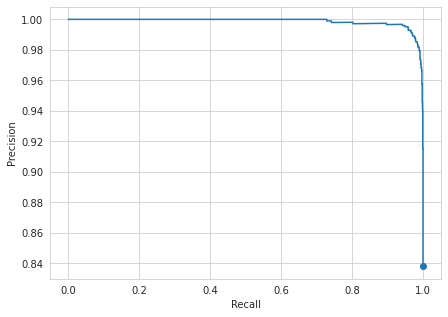

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.scatter(recall[0], precision[0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('pr_curve.png')

In [ ]:
from sklearn.metrics import precision_recall_curve

real = []
probs = []
s = nn.Sigmoid()
model.cuda()
model.eval()
device = 'cuda'

with torch.no_grad():
    for data in data_loader_test:
        X_batch = data['image'].to(device)
        Y_batch = data['label'].to(device)

        output = model(X_batch) 

        real += Y_batch.cpu().tolist()
        probs += s(output)[:, 0].cpu().tolist()


precision, recall, thresholds = precision_recall_curve(real, probs)

In [ ]:
# test
print(precision[:10])
print(recall[:10])
print(thresholds[:10])

[0.92872265 0.92867232 0.92862191 0.92927864 0.92993631 0.9305949
 0.93125443 0.93191489 0.9325763  0.93323864]
[1.         0.99924012 0.99848024 0.99848024 0.99848024 0.99848024
 0.99848024 0.99848024 0.99848024 0.99848024]
[0.15378772 0.15423967 0.15460101 0.15780905 0.1630509  0.16547595
 0.16669014 0.16869318 0.17238493 0.17376998]


In [ ]:
t = 0.01

In [ ]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(real, (np.array(probs) >= t) * 1)
print(CM)

[[ 986  289]
 [   0 1316]]
